In [1]:
import os, sys, glob

import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import scipy
import scipy.signal as signal
import mne
sys.path.append('../../')
import src.preprocessing as prep


In [2]:
from src.source_space import extract_label_tc

In [3]:
import numpy as np
from scipy import signal
from scipy import linalg



def ssd(Cband, Cbroad):
    """
    This fuction performs broadband spatio-spectral decomposition (SSD) on input signal.
    Args:

    Returns:
    """
    D, V = linalg.eigh(Cband)
    indx_descend = np.argsort(D)[::-1]
    V = V[:, indx_descend]
    D = D[indx_descend]

    # Estimate rank of covariance matrix
    tol = D[0] * 1e-6
    k = np.sum(D > tol)
    if(k < Cbroad.shape[0]):
        M = V[:, 0:k] @ np.diag(D[0:k]**(-0.5))
    else:
        M = np.eye(Cbroad.shape[0])
    Cband_r = M.T @ Cband @ M
    Cbroad_r = M.T @ Cbroad @ M
    # Generalized eigenvalue decomposition
    # Here I assume that the covariance matrix is positive definite.
    #D, W = linalg.eig(Cband_r, Cbroad_r)
    D, W = linalg.eigh(Cband_r, Cbroad_r)
    indx_descend = np.argsort(D)[::-1]
    W = W[:, indx_descend]
    W = M @ W

    return W

def extract_label_tc_deprecated(stc, labels, label_name, frange, sfreq, mode='broad'):
    """
    This function extracts time course from source estimate within a label.
    Args:
        stc: mne source estimate object (list of epochs)
        label: mne label (string)
        frange: frequency range of interest (list of two floats)
        sfreq: sampling frequency (float)
        mode: 'broad' or 'narrow' (string)
    """
    # Create label to index dictionary
    label2index = {label.name: i for i, label in enumerate(labels)}
    ix_label = label2index[label_name]
    tcs_label = [stc[e].in_label(labels[ix_label]).data for e in range(len(stc))]
    # Broadband covariance matrix
    c_broad = np.array([np.cov(tcs_label[e]) for e in range(len(tcs_label))]).mean(axis=0)
    # Narrowband covariance matrix
    # TODO
    # Covariance of signal in frequency band of interest
    tcs_label_filt = mne.filter.filter_data(tcs_label, sfreq=sfreq, l_freq=frange[0], h_freq=frange[1], method='iir', verbose=False)
    c_filt = np.array([np.cov(tcs_label_filt[e]) for e in range(len(tcs_label_filt))]).mean(axis=0)
    # spatial spectral decomposition (W is the spatial filter along which to project the label time courses)
    W = ssd(c_filt, c_broad)
    if np.all(np.isreal(W)):
        W = np.real(W)
    # Single time course per label
    tc_label = W[:, [0]].T @ np.array(tcs_label)

    return tc_label, W, tcs_label

In [5]:
def extract_label_tc(stc, labels, label_name, franges, sfreq, mode='broad'):
    """
    This function extracts time course from source estimate within a label.
    Args:
        stc: mne source estimate object (list of epochs)
        label: mne label (string)
        frange: frequency range of interest 
                    list of two floats where signal band is [frange[0], frange[1]], and noise band is broad band
                    or list of three lists of two floats: e.g. [[9, 11], [6, 15], [8, 12]] According to SSD paper
        sfreq: sampling frequency (float)
        mode: 'broad' or 'narrow' (string)
    """
    # Create label to index dictionary
    label2index = {label.name: i for i, label in enumerate(labels)}
    ix_label = label2index[label_name]
    tcs_label = [stc[e].in_label(labels[ix_label]).data for e in range(len(stc))]
    # Broadband covariance matrix
    if len(franges) == 2:
        c_noise = np.array([np.cov(tcs_label[e]) for e in range(len(tcs_label))]).mean(axis=0)
        tcs_label_sig = mne.filter.filter_data(tcs_label, sfreq=sfreq, l_freq=franges[0], h_freq=franges[1], method='iir', verbose=False)
        c_sig = np.array([np.cov(tcs_label_sig[e]) for e in range(len(tcs_label_sig))]).mean(axis=0)

    # Narrowband covariance matrix
    elif len(franges) == 3 and all([len(franges[k]) == 2 for k in range(len(franges))]):
        tcs_label_sig = mne.filter.filter_data(tcs_label, sfreq=sfreq, l_freq=franges[0][0], h_freq=franges[0][1], method='iir', verbose=False)
        c_sig = np.array([np.cov(tcs_label_sig[e]) for e in range(len(tcs_label_sig))]).mean(axis=0)
        tcs_label_widesig = mne.filter.filter_data(tcs_label, sfreq=sfreq, l_freq=franges[1][0], h_freq=franges[1][1], method='iir', verbose=False)
        #  Band stop filtering, According to MNE impl. of filter l_freq > h_freq: band-stop filter
        tcs_label_noise = mne.filter.filter_data(tcs_label_widesig, sfreq=sfreq, l_freq=franges[2][1], h_freq=franges[2][0], method='iir', verbose=False)
        c_sig = np.array([np.cov(tcs_label_noise[e]) for e in range(len(tcs_label_noise))]).mean(axis=0)    
    
    # spatial spectral decomposition (W is the spatial filter along which to project the label time courses)
    W = ssd(c_sig, c_noise)
    if np.all(np.isreal(W)):
        W = np.real(W)
    # Single time course per label
    tc_label = W[:, [0]].T @ np.array(tcs_label)

    return tc_label, W, tcs_label

In [3]:

### Set directories
for subj_id in range(13, 14):

    condition = 'encoding'#'maintenance'
    condition_acr = 'e'#'m'

    subj_name = f'subj_{subj_id}'
    print(os.listdir('../'))
    plots_path = '../../datasets/plots/'
    data_path = '../../datasets/data/'
    meg_dir = os.path.join(data_path, f'subj_{subj_id}', 'meg')
    mri_dir = os.path.join(data_path, f'subj_{subj_id}', 'mri')
    fs_subjs_dir = os.path.join(data_path, 'fs_subjects_dir')

    srcs_dir = os.path.join(plots_path, subj_name, 'source_space')
    os.makedirs(srcs_dir, exist_ok=True)
    srcs_itc_dir = os.path.join(plots_path, subj_name, 'source_space_itc', condition)
    os.makedirs(srcs_itc_dir, exist_ok=True)

    # Load after-ICA MEG data
    if os.path.isfile(os.path.join(meg_dir, f'after_ica_subj_{subj_id}_meg.fif')):
        meg = mne.io.read_raw_fif(os.path.join(meg_dir, f'after_ica_subj_{subj_id}_meg.fif'), verbose=False)
    else:
        meg = mne.io.read_raw_fif(os.path.join(meg_dir, f'after_ica_meg.fif'), verbose=False)

    # Load atlas labels
    labels = mne.read_labels_from_annot(subject=subj_name, parc='BN_Atlas', hemi='both', 
                                surf_name='white', annot_fname=None, regexp=None, 
                                subjects_dir=fs_subjs_dir, sort=True, verbose=False)
    # Load forward model
    fwd = mne.read_forward_solution(os.path.join(mri_dir, 'file-fwd.fif'))

    itpc_pca, xfreq_pca, itpc_ssd, xfreq_ssd = [], [], [], []


    for j, fm in enumerate(['1.0', '1.5', '2.0', '2.5', '3.0', '3.5', '4.0']):
    #for j, fm in enumerate(['1.0']):


        print(f'===> Processing subj: {subj_id}    fm= {fm} Hz')


        # Estimate noine covariance matrices from all trials, tmin=-.2 tmax=-0.05 
        _epoch = prep.mk_epochs(meg.copy(), mod_freq=float(fm), tmin=-0.2, baseline=None, 
                        annot_pattern=f'{condition_acr}/{fm}', new_event_value=101)
        noise_cov = mne.compute_covariance(_epoch, tmin=-0.2, tmax=-0.05,
                                        method='empirical')

        # Obtain separate Epochs for phase 0 and pi
        epoch0 = prep.mk_epochs(meg.copy(), mod_freq=float(fm), tmin=0, baseline=None, 
                        annot_pattern=f'{condition_acr}/{fm}/e0/', new_event_value=101)
        epochpi = prep.mk_epochs(meg.copy(), mod_freq=float(fm), tmin=0, baseline=None, 
                        annot_pattern=f'{condition_acr}/{fm}/epi/', new_event_value=101)
        print(epoch0.get_data().shape, epoch0.info['sfreq'])
        print(epochpi.get_data().shape, epochpi.info['sfreq'])

        # Shift phase of pi trials by pi
        sig_shifted = prep.shift_phase(epochpi.copy().get_data(), dphi=np.pi, f=float(fm), fs=meg.info['sfreq'])
        print(sig_shifted.shape)

        # Create new Epochs object for shifted pi trials
        epochpi_shifted = mne.EpochsArray(sig_shifted, epochpi.info, tmin=epochpi.tmin)

        #epochpi_shifted.plot_psd(fmin=0, fmax=100, average=True, spatial_colors=False, n_jobs=1, show=False)

        # Concatenate epochs with phase 0 and shifted pi trials
        epoch = mne.concatenate_epochs([epoch0, epochpi_shifted])

        # Estimate data covariance from aligned trials, tmin=0 tmax=8/fm
        data_cov = mne.compute_covariance(epoch, tmin=0.0, tmax=8/float(fm),
                                        method='empirical')

        # Visualize noise and data covariance matrices
        #with mne.viz.use_browser_backend('matplotlib'):
        #    mne.viz.plot_cov(noise_cov, meg.info)

        # Source Reconstruction: MNE
        inv_operator = mne.minimum_norm.make_inverse_operator(epoch.info, fwd, data_cov,
                                                            loose=0.2, depth=0.8, verbose=True)
        method = "dSPM"
        snr = 3.
        lambda2 = 1. / snr ** 2
        stc = mne.minimum_norm.apply_inverse_epochs(epoch, inv_operator, lambda2, method=method, 
                                pick_ori='normal', verbose=False)
        
        # Read Atlas labels for subject
        labels = mne.read_labels_from_annot(subject=subj_name, parc='BN_Atlas', hemi='both', 
                                        surf_name='white', annot_fname=None, regexp=None, 
                                        subjects_dir=fs_subjs_dir, sort=True, verbose=False)
        
        ### PCA based calculation of ITC
        # Create label to index dictionary

        label2index = {label.name: i for i, label in enumerate(labels)}
        if 0:
            # Time courses for all epochs and all labels (pca across dipoles)
            stc_labels = np.array([k.extract_label_time_course(labels=labels, src=inv_operator['src'], mode='pca_flip', verbose=False) for k in stc])
            stc_labels.shape # (num_epochs, num_labels, num_times)

            _itpc, _xfreq, *_ = prep.calc_itc(stc_labels, meg.info['sfreq'])
            itpc_pca.append(_itpc)
            xfreq_pca.append(_xfreq)

        ### SSD based calculation of ITC
        franges = [float(fm)-.1*float(fm), float(fm)+.1*float(fm)]
        stc_labels_ssd = np.array([extract_label_tc(stc, label_name=l.name, labels=labels,
                                            franges=franges, sfreq=meg.info['sfreq'], mode='broad')[0] for l in labels])

        _itpc, _xfreq, *_ = prep.calc_itc(np.swapaxes(stc_labels_ssd.squeeze(), 0, 1), meg.info['sfreq'])
        itpc_ssd.append(_itpc)
        xfreq_ssd.append(_xfreq)

        print(f"===> {fm} Hz done!")




['test_ssd', 'sync_subjs.sh', 'nf_codes', '.DS_Store', 'sensor_itc.ipynb', 'srcs_pac.ipynb', 'copied_codes', 'workflow_source_reconstruction.py', 'workflow_source_analysis.py', 'data_preparation', 'forward_modeling', 'srcs_pac_v1.ipynb', 'wf_sr_phamp.py', 'srcs_comp_pac_v1.ipynb', 'source_reconstruction', 'preprocessing', 'wf_source_reconstruction_itc.py', 'srcs_comp_itc_pow.ipynb', 'outputs', 'srcs_viz_itc_pow.ipynb', 'srcs_erf.ipynb', 'wf_source_reconstruction.py', 'wf_sr_tfr.py']
Reading forward solution from /Users/keyvan.mahjoory/k1_analyses/prj_neuroflex/neuroflex_analysis/notebooks/test_ssd/../../datasets/data/subj_13/mri/file-fwd.fif...
    Reading a source space...
    Computing patch statistics...
    Patch information added...
    Distance information added...
    [done]
    Reading a source space...
    Computing patch statistics...
    Patch information added...
    Distance information added...
    [done]
    2 source spaces read
    Desired named matrix (kind = 3523) not

/var/folders/cn/42yytr0j3dl9t4k24ldqk59h0000gq/T/ipykernel_56555/3946413318.py:67: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  epoch = mne.concatenate_epochs([epoch0, epochpi_shifted])


Not setting metadata
72 matching events found
No baseline correction applied
Removing 5 compensators from info because not all compensation channels were picked.
Computing rank from data with rank=None
    Using tolerance 7.5e-08 (2.2e-16 eps * 275 dim * 1.2e+06  max singular value)
    Estimated rank (mag): 275
    MAG: rank 275 computed from 275 data channels with 0 projectors
Reducing data rank from 275 -> 275
Estimating covariance using EMPIRICAL
Done.
Number of samples used : 172800
[done]
Converting forward solution to surface orientation
    Average patch normals will be employed in the rotation to the local surface coordinates....
    Converting to surface-based source orientations...
    [done]
Computing inverse operator with 275 channels.
    275 out of 275 channels remain after picking
Removing 5 compensators from info because not all compensation channels were picked.
Selected 275 channels
Creating the depth weighting matrix...
    275 magnetometer or axial gradiometer chan

/var/folders/cn/42yytr0j3dl9t4k24ldqk59h0000gq/T/ipykernel_56555/3946413318.py:67: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  epoch = mne.concatenate_epochs([epoch0, epochpi_shifted])


Not setting metadata
72 matching events found
No baseline correction applied
Removing 5 compensators from info because not all compensation channels were picked.
Computing rank from data with rank=None
    Using tolerance 6.2e-08 (2.2e-16 eps * 275 dim * 1e+06  max singular value)
    Estimated rank (mag): 275
    MAG: rank 275 computed from 275 data channels with 0 projectors
Reducing data rank from 275 -> 275
Estimating covariance using EMPIRICAL
Done.
Number of samples used : 115200
[done]
Converting forward solution to surface orientation
    Average patch normals will be employed in the rotation to the local surface coordinates....
    Converting to surface-based source orientations...
    [done]
Computing inverse operator with 275 channels.
    275 out of 275 channels remain after picking
Removing 5 compensators from info because not all compensation channels were picked.
Selected 275 channels
Creating the depth weighting matrix...
    275 magnetometer or axial gradiometer channe

/var/folders/cn/42yytr0j3dl9t4k24ldqk59h0000gq/T/ipykernel_56555/3946413318.py:67: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  epoch = mne.concatenate_epochs([epoch0, epochpi_shifted])


Not setting metadata
72 matching events found
No baseline correction applied
Removing 5 compensators from info because not all compensation channels were picked.
Computing rank from data with rank=None
    Using tolerance 5.4e-08 (2.2e-16 eps * 275 dim * 8.9e+05  max singular value)
    Estimated rank (mag): 275
    MAG: rank 275 computed from 275 data channels with 0 projectors
Reducing data rank from 275 -> 275
Estimating covariance using EMPIRICAL
Done.
Number of samples used : 86400
[done]
Converting forward solution to surface orientation
    Average patch normals will be employed in the rotation to the local surface coordinates....
    Converting to surface-based source orientations...
    [done]
Computing inverse operator with 275 channels.
    275 out of 275 channels remain after picking
Removing 5 compensators from info because not all compensation channels were picked.
Selected 275 channels
Creating the depth weighting matrix...
    275 magnetometer or axial gradiometer chann

/var/folders/cn/42yytr0j3dl9t4k24ldqk59h0000gq/T/ipykernel_56555/3946413318.py:67: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  epoch = mne.concatenate_epochs([epoch0, epochpi_shifted])


Not setting metadata
72 matching events found
No baseline correction applied
Removing 5 compensators from info because not all compensation channels were picked.
Computing rank from data with rank=None
    Using tolerance 4.6e-08 (2.2e-16 eps * 275 dim * 7.6e+05  max singular value)
    Estimated rank (mag): 275
    MAG: rank 275 computed from 275 data channels with 0 projectors
Reducing data rank from 275 -> 275
Estimating covariance using EMPIRICAL
Done.
Number of samples used : 69120
[done]
Converting forward solution to surface orientation
    Average patch normals will be employed in the rotation to the local surface coordinates....
    Converting to surface-based source orientations...
    [done]
Computing inverse operator with 275 channels.
    275 out of 275 channels remain after picking
Removing 5 compensators from info because not all compensation channels were picked.
Selected 275 channels
Creating the depth weighting matrix...
    275 magnetometer or axial gradiometer chann

/var/folders/cn/42yytr0j3dl9t4k24ldqk59h0000gq/T/ipykernel_56555/3946413318.py:67: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  epoch = mne.concatenate_epochs([epoch0, epochpi_shifted])


No baseline correction applied
Removing 5 compensators from info because not all compensation channels were picked.
Computing rank from data with rank=None
    Using tolerance 4.2e-08 (2.2e-16 eps * 275 dim * 6.9e+05  max singular value)
    Estimated rank (mag): 275
    MAG: rank 275 computed from 275 data channels with 0 projectors
Reducing data rank from 275 -> 275
Estimating covariance using EMPIRICAL
Done.
Number of samples used : 57600
[done]
Converting forward solution to surface orientation
    Average patch normals will be employed in the rotation to the local surface coordinates....
    Converting to surface-based source orientations...
    [done]
Computing inverse operator with 275 channels.
    275 out of 275 channels remain after picking
Removing 5 compensators from info because not all compensation channels were picked.
Selected 275 channels
Creating the depth weighting matrix...
    275 magnetometer or axial gradiometer channels
    limit = 8012/8196 = 10.022025
    scal

/var/folders/cn/42yytr0j3dl9t4k24ldqk59h0000gq/T/ipykernel_56555/3946413318.py:67: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  epoch = mne.concatenate_epochs([epoch0, epochpi_shifted])


Removing 5 compensators from info because not all compensation channels were picked.
Computing rank from data with rank=None
    Using tolerance 4e-08 (2.2e-16 eps * 275 dim * 6.5e+05  max singular value)
    Estimated rank (mag): 275
    MAG: rank 275 computed from 275 data channels with 0 projectors
Reducing data rank from 275 -> 275
Estimating covariance using EMPIRICAL
Done.
Number of samples used : 49392
[done]
Converting forward solution to surface orientation
    Average patch normals will be employed in the rotation to the local surface coordinates....
    Converting to surface-based source orientations...
    [done]
Computing inverse operator with 275 channels.
    275 out of 275 channels remain after picking
Removing 5 compensators from info because not all compensation channels were picked.
Selected 275 channels
Creating the depth weighting matrix...
    275 magnetometer or axial gradiometer channels
    limit = 8012/8196 = 10.022025
    scale = 7.9076e-11 exp = 0.8
Applying

/var/folders/cn/42yytr0j3dl9t4k24ldqk59h0000gq/T/ipykernel_56555/3946413318.py:67: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  epoch = mne.concatenate_epochs([epoch0, epochpi_shifted])


Computing rank from data with rank=None
    Using tolerance 4e-08 (2.2e-16 eps * 275 dim * 6.5e+05  max singular value)
    Estimated rank (mag): 275
    MAG: rank 275 computed from 275 data channels with 0 projectors
Reducing data rank from 275 -> 275
Estimating covariance using EMPIRICAL
Done.
Number of samples used : 43200
[done]
Converting forward solution to surface orientation
    Average patch normals will be employed in the rotation to the local surface coordinates....
    Converting to surface-based source orientations...
    [done]
Computing inverse operator with 275 channels.
    275 out of 275 channels remain after picking
Removing 5 compensators from info because not all compensation channels were picked.
Selected 275 channels
Creating the depth weighting matrix...
    275 magnetometer or axial gradiometer channels
    limit = 8012/8196 = 10.022025
    scale = 7.9076e-11 exp = 0.8
Applying loose dipole orientations to surface source spaces: 0.2
Whitening the forward soluti

IndexError: list index out of range

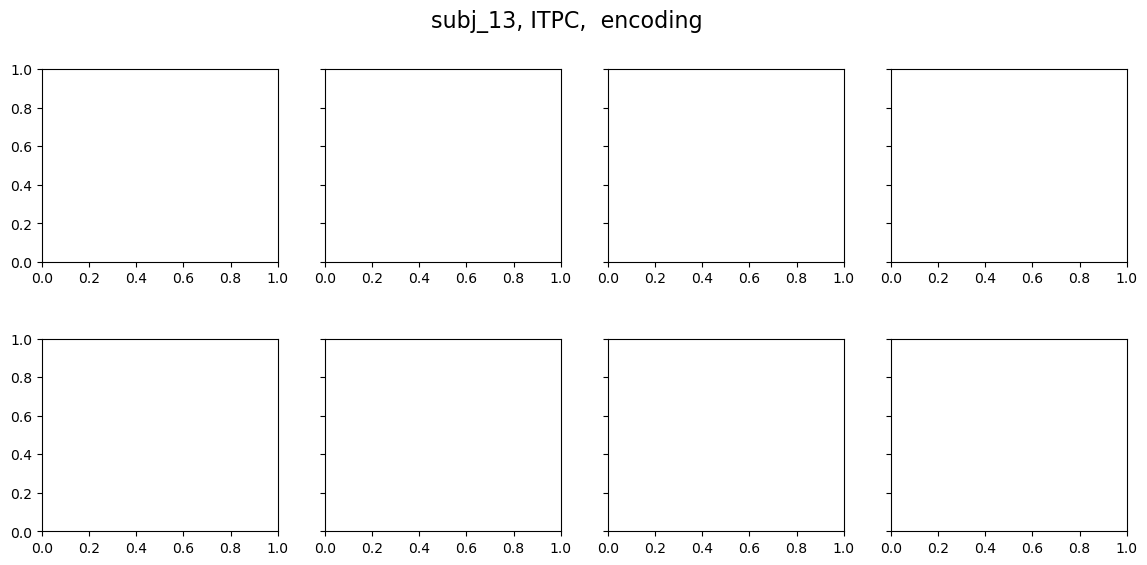

In [7]:
stg_l = ['A38m_L-lh', 'A41/42_L-lh', 'TE1.0/TE1.2_L-lh', 'A22c_L-lh',  'A22r_L-lh']    #'A38l_L-lh',
stg_r = ['A38m_R-rh', 'A41/42_R-rh', 'TE1.0/TE1.2_R-rh', 'A22c_R-rh', 'A22r_R-rh'] # , 'A38l_R-rh'

fig, ax = plt.subplots(2, 4, sharex=False, sharey=True, figsize=(14, 6))
fig.suptitle(f'{subj_name}, ITPC,  {condition}', fontsize=16)
plt.subplots_adjust(hspace=0.4)
for j, fm in enumerate(['1.0', '1.5', '2.0', '2.5', '3.0', '3.5', '4.0']):
    for label_name in stg_r+stg_l:
        _ix_roi = label2index[label_name]
        ax[j//4, j%4].plot(xfreq_pca[j], itpc_pca[j][_ix_roi, :].T)
    
    ax[j//4, j%4].set_title(f'fm= {fm} Hz')
    ax[j//4, j%4].set_xlim(0.5, 4.3)
    #ax[j//4, j%4].set_ylim(0, 2000)
    ax[j//4, j%4].set_xticks([1, 1.5, 2, 2.5, 3, 3.5, 4])
    #ax[j//4, j%4].set_yticks([])
    ax[j//4, j%4].spines['top'].set_visible(False)
    ax[j//4, j%4].spines['right'].set_visible(False)
    #ax[j//4, j%4].spines['left'].set_visible(False)
    #ax[j//4, j%4].grid(True)
    ax[0, 0].set_ylabel('ITPC')
    ax[1, 0].set_ylabel('ITPC')
    if j==5:
        fig.legend(stg_r+stg_l, loc='lower right');
    
plt.delaxes(ax[1, 3]) ;
plt.savefig(os.path.join(srcs_itc_dir, f'itpc_seeds_{condition}_test.png'), dpi=300)



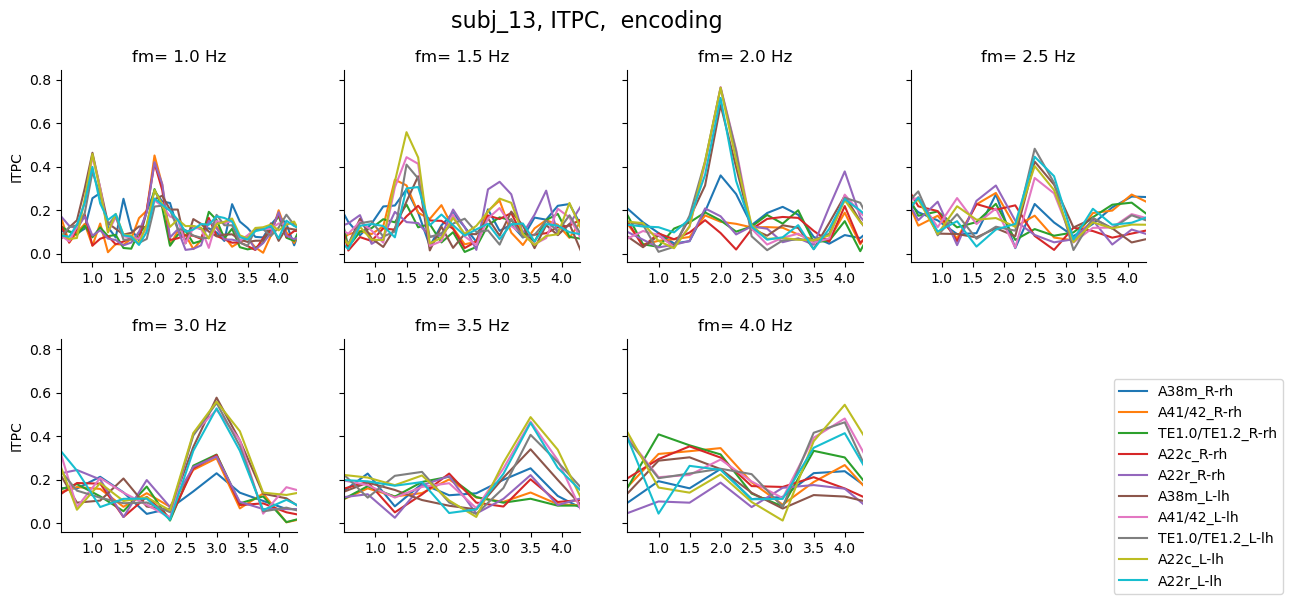

In [4]:
stg_l = ['A38m_L-lh', 'A41/42_L-lh', 'TE1.0/TE1.2_L-lh', 'A22c_L-lh',  'A22r_L-lh']    #'A38l_L-lh',
stg_r = ['A38m_R-rh', 'A41/42_R-rh', 'TE1.0/TE1.2_R-rh', 'A22c_R-rh', 'A22r_R-rh'] # , 'A38l_R-rh'

fig, ax = plt.subplots(2, 4, sharex=False, sharey=True, figsize=(14, 6))
fig.suptitle(f'{subj_name}, ITPC,  {condition}', fontsize=16)
plt.subplots_adjust(hspace=0.4)
for j, fm in enumerate(['1.0', '1.5', '2.0', '2.5', '3.0', '3.5', '4.0']):
    for label_name in stg_r+stg_l:
        _ix_roi = label2index[label_name]
        ax[j//4, j%4].plot(xfreq_ssd[j], itpc_ssd[j][_ix_roi, :].T)
    
    ax[j//4, j%4].set_title(f'fm= {fm} Hz')
    ax[j//4, j%4].set_xlim(0.5, 4.3)
    #ax[j//4, j%4].set_ylim(0, 2000)
    ax[j//4, j%4].set_xticks([1, 1.5, 2, 2.5, 3, 3.5, 4])
    #ax[j//4, j%4].set_yticks([])
    ax[j//4, j%4].spines['top'].set_visible(False)
    ax[j//4, j%4].spines['right'].set_visible(False)
    #ax[j//4, j%4].spines['left'].set_visible(False)
    #ax[j//4, j%4].grid(True)
    ax[0, 0].set_ylabel('ITPC')
    ax[1, 0].set_ylabel('ITPC')
    if j==5:
        fig.legend(stg_r+stg_l, loc='lower right');
    
plt.delaxes(ax[1, 3]) ;
plt.savefig(os.path.join(srcs_itc_dir, f'itpc_seeds_{condition}_ssd.png'), dpi=300)

In [ ]:

print(itpc_pca.shape, xfreq_pca.shape)
stg_l = ['A38m_L-lh', 'A41/42_L-lh', 'TE1.0/TE1.2_L-lh', 'A22c_L-lh',  'A22r_L-lh']    #'A38l_L-lh',
stg_r = ['A38m_R-rh', 'A41/42_R-rh', 'TE1.0/TE1.2_R-rh', 'A22c_R-rh', 'A22r_R-rh'] # , 'A38l_R-rh'
for label_name in stg_r+stg_l:
    ix_roi = label2index[label_name]
    plt.plot(xfreq, itpc_pca[ix_roi, :].T)
    plt.title(f'fm= {fm} Hz')
    plt.xlim(0.5, 4.3)
    #ax[j//4, j%4].set_ylim(0, 2000)
    plt.xticks([1, 1.5, 2, 2.5, 3, 3.5, 4])

In [ ]:
label_sel = 'A22r_L-lh'    #'A38l_L-lh',
ix_roi = label2index[label_name];
plt.plot(xfreq, itpc[ix_roi, :].T)
plt.title(f'fm= {fm} Hz')
plt.xlim(0.5, 4.3)
plt.xticks([1, 1.5, 2, 2.5, 3, 3.5, 4])
plt.show()

In [ ]:
import numpy as np
from scipy import signal
from scipy import linalg
import numpy as np

In [ ]:
label_name

In [ ]:
label_sel = 'A22r_L-lh'
ix_roi = label2index[label_name]
print(ix_roi)
tcs_label = [stc[e].in_label(labels[ix_roi]).data for e in range(len(stc))]
print(tcs_label[0].shape)

c_broad = np.array([np.cov(tcs_label[e]) for e in range(len(tcs_label))]).mean(axis=0)
fm = 2.
tcs_label_filt = mne.filter.filter_data(tcs_label, sfreq=meg.info['sfreq'], l_freq=fm-.25, h_freq=fm+.25, method='iir')
c_filt = np.array([np.cov(tcs_label_filt[e]) for e in range(len(tcs_label_filt))]).mean(axis=0)
#comp_tcs = V[:, 0].reshape(1, -1) @ np.array(label_tcs)


W = ssd(c_filt, c_broad)
if np.all(np.isreal(W)):
    W = np.real(W)

print(len(tcs_label_filt), len(tcs_label), tcs_label_filt[0].shape, tcs_label[0].shape)
print(c_filt.shape, c_broad.shape, W.shape)



In [ ]:
import numpy as np
from scipy import signal
from scipy import linalg



def ssd(Cband, Cbroad):
    """
    This fuction performs broadband spatio-spectral decomposition (SSD) on input signal.
    Args:

    Returns:
    """
    D, V = linalg.eigh(Cband)
    indx_descend = np.argsort(D)[::-1]
    V = V[:, indx_descend]
    D = D[indx_descend]

    # Estimate rank of covariance matrix
    tol = D[0] * 1e-6
    k = np.sum(D > tol)
    if(k < Cbroad.shape[0]):
        M = V[:, 0:k] @ np.diag(D[0:k]**(-0.5))
    else:
        M = np.eye(Cbroad.shape[0])
    Cband_r = M.T @ Cband @ M
    Cbroad_r = M.T @ Cbroad @ M
    # Generalized eigenvalue decomposition
    # Here I assume that the covariance matrix is positive definite.
    #D, W = linalg.eig(Cband_r, Cbroad_r)
    D, W = linalg.eigh(Cband_r, Cbroad_r)
    indx_descend = np.argsort(D)[::-1]
    W = W[:, indx_descend]
    W = M @ W

    return W

In [ ]:
def extract_label_tc(stc, labels, label_name, frange, sfreq, mode='broad'):
    """
    This function extracts time course from source estimate within a label.
    Args:
        stc: mne source estimate object (list of epochs)
        label: mne label (string)
        frange: frequency range of interest (list of two floats)
        sfreq: sampling frequency (float)
        mode: 'broad' or 'narrow' (string)
    """
    # Create label to index dictionary
    label2index = {label.name: i for i, label in enumerate(labels)}
    ix_label = label2index[label_name]
    tcs_label = [stc[e].in_label(labels[ix_label]).data for e in range(len(stc))]
    # Broadband covariance matrix
    c_broad = np.array([np.cov(tcs_label[e]) for e in range(len(tcs_label))]).mean(axis=0)
    # Narrowband covariance matrix
    # TODO
    # Covariance of signal in frequency band of interest
    tcs_label_filt = mne.filter.filter_data(tcs_label, sfreq=sfreq, l_freq=frange[0], h_freq=frange[1], method='iir', verbose=False)
    c_filt = np.array([np.cov(tcs_label_filt[e]) for e in range(len(tcs_label_filt))]).mean(axis=0)
    # spatial spectral decomposition (W is the spatial filter along which to project the label time courses)
    W = ssd(c_filt, c_broad)
    if np.all(np.isreal(W)):
        W = np.real(W)
    # Single time course per label
    tc_label = W[:, [0]].T @ np.array(tcs_label)

    return tc_label, W, tcs_label


    


In [ ]:
label_sel = 'A22r_L-lh'
fm = 2.
tc_label_sel, *_ = extract_label_tc(stc, label_name=label_sel, frange=[fm-.25, fm+.25], sfreq=meg.info['sfreq'], mode='broad')
print(tc_label_sel.shape)

_itpc, _xfreq, *_ = prep.calc_itc(tc_label_sel, meg.info['sfreq'])
plt.plot(_xfreq, _itpc)
plt.plot(xfreq, it)
plt.title(f'fm= {fm} Hz')
plt.xlim(0.5, 4.3)
plt.xticks([1, 1.5, 2, 2.5, 3, 3.5, 4])
plt.show()

In [ ]:
stg_l = ['A38m_L-lh', 'A41/42_L-lh', 'TE1.0/TE1.2_L-lh', 'A22c_L-lh',  'A22r_L-lh']    #'A38l_L-lh',
stg_r = ['A38m_R-rh', 'A41/42_R-rh', 'TE1.0/TE1.2_R-rh', 'A22c_R-rh', 'A22r_R-rh'] # , 'A38l_R-rh'
itpc_sel = []
for label_sel in stg_r+stg_l:
    #ix_roi = label2index[label_name]
    fm = 2.
    tc_label_sel, *_ = extract_label_tc(stc, label_name=label_sel, frange=[fm-.25, fm+.25], sfreq=meg.info['sfreq'], mode='broad')
    _itpc, _xfreq, *_ = prep.calc_itc(tc_label_sel, meg.info['sfreq'])
    itpc_sel.append(_itpc)
 

In [ ]:
   
plt.plot(_xfreq, np.array(itpc_sel).T)
plt.title(f'fm= {fm} Hz')
plt.xlim(0.5, 4.3)
plt.xticks([1, 1.5, 2, 2.5, 3, 3.5, 4])
plt.show()
  

In [ ]:
np.array(itpc_sel).shape
itpc_sel[1]